[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Naive Bayes Model Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.87      0.86       292
    positive       0.87      0.85      0.86       308

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



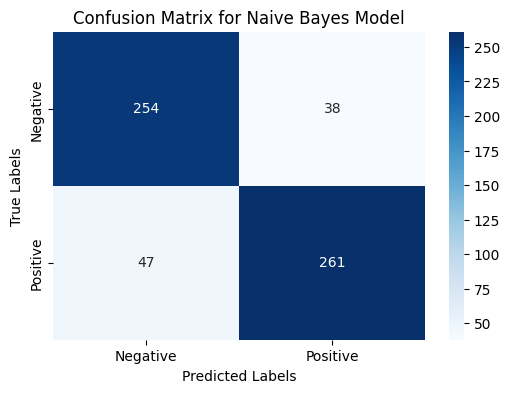

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
import nltk

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function with lemmatization and custom stopwords
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Load and preprocess the data
file_path = 'IMDB_Dataset.csv'
df = pd.read_csv(file_path)
df['processed_review'] = df['review'].apply(preprocess_text)
df_sample = df.sample(n=3000, random_state=42)  # Increase sample size for better training

# Define X and y
X = df_sample['processed_review']
y = df_sample['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the data with a combination of TF-IDF and CountVectorizer for better feature extraction
tfidf_vectorizer = TfidfVectorizer(
    max_features=25000,  # Increase the feature limit
    ngram_range=(1, 2),  # Use unigrams and bigrams for context
    min_df=5,
    max_df=0.85,
    stop_words='english'  # Built-in stop words for better efficiency
)
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_vec_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# Model: Multinomial Naive Bayes with hyperparameter tuning
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 3.0]  # Different values for Laplace smoothing
}
nb_model = MultinomialNB()
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=3, scoring='accuracy')
grid_search_nb.fit(X_train_vec_resampled, y_train_resampled)

# Best model
best_model_nb = grid_search_nb.best_estimator_

# Predictions and evaluation
y_pred_nb = best_model_nb.predict(X_test_vec)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Model Accuracy: {accuracy_nb:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Naive Bayes Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
